In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kinematics-motion-data/Kinematics_Data.csv


In [2]:
df = pd.read_csv('/kaggle/input/kinematics-motion-data/Kinematics_Data.csv')

# Data Analysis

In [3]:
df.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


Time, date are input features that are not relevant to define the activity of motion taken by the user so they can be droped, along with the username since it is always the same as we can see below.

In [4]:
df['username'].value_counts()

viktor    88588
Name: username, dtype: int64

In [5]:
df.drop(['date', 'time', 'username'], axis = 1, inplace = True)

In [6]:
df.head()

,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


In [7]:
df.isnull().sum()

wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

As we also see we have no missing value to take care of!

# Data Train Test Split

In [8]:
X = df.drop('activity',axis=1).values
y = df['activity'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=33)

scaler = MinMaxScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
#y_train = F.one_hot(torch.LongTensor(y_train))  # not needed with Cross Entropy Loss
#y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define The Model

In [9]:
class Model(nn.Module):
    def __init__(self, in_features=7, h1=10, h2=9, out_features=2):
        super().__init__()
        
        # input layer -> 1 hidden -> 2 hidden -> output 
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        # Pass the neuron input through its activation function to obtain the output of the neuron
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [10]:
torch.manual_seed(4)
model = Model()

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the Model

In [12]:
epochs = 500 # number of runs through the training data
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad() #zero-grad to not accomulate the gradient over the epochs
    loss.backward()
    optimizer.step()

epoch:  1  loss: 0.69131511
epoch: 11  loss: 0.66810387
epoch: 21  loss: 0.60499859
epoch: 31  loss: 0.47455353
epoch: 41  loss: 0.34843293
epoch: 51  loss: 0.28557786
epoch: 61  loss: 0.25532621
epoch: 71  loss: 0.23842455
epoch: 81  loss: 0.22505544
epoch: 91  loss: 0.21202309
epoch: 101  loss: 0.19992615
epoch: 111  loss: 0.18831246
epoch: 121  loss: 0.17779274
epoch: 131  loss: 0.16816962
epoch: 141  loss: 0.15844426
epoch: 151  loss: 0.14955160
epoch: 161  loss: 0.14199583
epoch: 171  loss: 0.13656706
epoch: 181  loss: 0.13029936
epoch: 191  loss: 0.12521356
epoch: 201  loss: 0.12089445
epoch: 211  loss: 0.11720345
epoch: 221  loss: 0.11389735
epoch: 231  loss: 0.11119810
epoch: 241  loss: 0.10973215
epoch: 251  loss: 0.10712312
epoch: 261  loss: 0.10528143
epoch: 271  loss: 0.10332728
epoch: 281  loss: 0.10286519
epoch: 291  loss: 0.10083362
epoch: 301  loss: 0.09941188
epoch: 311  loss: 0.09849538
epoch: 321  loss: 0.09726483
epoch: 331  loss: 0.09977455
epoch: 341  loss: 0.0956

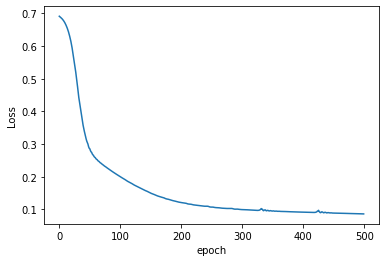

In [13]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [14]:
Test_Predictions = torch.max(y_pred,1)[1]
print(Test_Predictions)

tensor([0, 1, 0,  ..., 0, 0, 0])


# Evaluate The Model

In [15]:
with torch.no_grad():
    y_test_pred = model.forward(X_test)

In [16]:
y_test_pred = torch.max(y_test_pred,1)[1]

In [17]:
print(confusion_matrix(y_test, y_test_pred))
print('---------------------------------------------------------')
print(classification_report(y_test, y_test_pred))

[[13008   180]
 [  594 12795]]
---------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     13188
           1       0.99      0.96      0.97     13389

    accuracy                           0.97     26577
   macro avg       0.97      0.97      0.97     26577
weighted avg       0.97      0.97      0.97     26577

